In [1]:
import sys, os, glob
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from PIL import Image
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from DGXutils import GetFileNames, GetLowestGPU

sys.path.append('../')

from utils.Metrics import iou
from utils.Preprocessing import split_image

# Test Significance Between Loss Functions

In [2]:
# get accuracy per image for each model
base_path = '../data/test/{}_test_predictions_by_pod/'

vanilla_path = base_path.format('vanilla')
up_path = base_path.format('up')
down_path = base_path.format('down')

gt_path = '../data/test/test_masks_by_pod/'

# only need one set of names since they are the same for all models
gt_names = GetFileNames(gt_path)

In [3]:
# load the data
vanilla_preds, up_preds, down_preds, gt_masks = [], [], [], []

print('Loading data...')
for name in tqdm(gt_names):
    # load
    vanilla_pred = np.array(Image.open(vanilla_path + 'pred_' + name)) / 255
    up_pred = np.array(Image.open(up_path + 'pred_' + name)) / 255
    down_pred = np.array(Image.open(down_path + 'pred_' + name)) / 255

    # turn bg to black
    vanilla_pred[vanilla_pred.sum(axis=2) == 3] = 0
    up_pred[up_pred.sum(axis=2) == 3] = 0
    down_pred[down_pred.sum(axis=2) == 3] = 0

    # append
    vanilla_preds.append(vanilla_pred)
    up_preds.append(up_pred)
    down_preds.append(down_pred)

    gt_masks.append(np.array(Image.open(gt_path + name)) / 255)
print("Done.")

Loading data...


  0%|          | 0/64 [00:00<?, ?it/s]

Done.


In [4]:
# get accuracies for each model
vanilla_seed_acc, up_seed_acc, down_seed_acc = [], [], []

print("Calculating accuracies...")
for i in tqdm(range(len(gt_masks))):
    vanilla, up, down, mask = vanilla_preds[i], up_preds[i], down_preds[i], gt_masks[i]

    vanilla_seed = vanilla[:, :, 2]
    up_seed = up[:, :, 2]
    down_seed = down[:, :, 2]
    mask_seed = mask[:, :, 2]

    vanilla_seed_acc.append(iou(vanilla_seed, mask_seed))
    up_seed_acc.append(iou(up_seed, mask_seed))
    down_seed_acc.append(iou(down_seed, mask_seed))
print("Done.")
    

Calculating accuracies...


  0%|          | 0/64 [00:00<?, ?it/s]

Done.


In [5]:
np.array(vanilla_seed_acc).mean(), np.array(up_seed_acc).mean(), np.array(down_seed_acc).mean()

(0.7692997804533273, 0.7666305824958907, 0.7718830387601895)

# Seed Model Significance Test

In [6]:
# create dataframe
seed_df = pd.DataFrame({
    'vanilla': vanilla_seed_acc,
    'upweighted': up_seed_acc,
    'downweighted': down_seed_acc
})
seed_df_melt = pd.melt(seed_df.reset_index(), id_vars=['index'], value_vars=['vanilla', 'upweighted', 'downweighted'])
seed_df_melt.columns = ['index', 'treatments', 'value']

In [7]:
# run ANOVA
model = ols('value ~ C(treatments)', data=seed_df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print()

                 sum_sq     df         F    PR(>F)
C(treatments)  0.000883    2.0  0.035066  0.965548
Residual       2.379375  189.0       NaN       NaN



In [8]:
# run tukey HSD test
m_comp = pairwise_tukeyhsd(endog=seed_df_melt['value'], groups=seed_df_melt['treatments'], alpha=0.05)
print(m_comp)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
downweighted upweighted  -0.0053 0.9621 -0.0521 0.0416  False
downweighted    vanilla  -0.0026 0.9907 -0.0494 0.0443  False
  upweighted    vanilla   0.0027 0.9901 -0.0442 0.0495  False
-------------------------------------------------------------


# Model v. Human Significance Test

In [9]:
# get accuracy per image for each model
out_path = '../data/human_eval_by_pod/'
john_path = out_path + 'john/490-ref-ISU_073-rep_1-W - JL_{}.png'
bill_path = out_path + 'bill/BILL_490-ref-ISU_073-rep_1-W_{}.png'
roshan_path = out_path + 'roshan/CRA_outline_{}.png'
pete_path = out_path + 'pete/pete_490-ref-ISU_073-rep_1-W_{}.png'
avg_path = out_path + 'avg/avg_pred_{}.png'

model_path = '/mnt/DGX01/Personal/krusepi/codebase/projects/phenotyping/PennycressUNet/data/test/vanilla_test_predictions_by_pod/pred_490-ref-ISU_073-rep_1-W_{}.png'

# only need one set of names since they are the same for all models
names = GetFileNames(out_path + 'pete/')

In [10]:
# load the data
model_preds, john_preds, bill_preds, pete_preds, roshan_preds, avg_preds = [], [], [], [], [], []

print('Loading data...')
for i in tqdm(range(len(names))):
    # load
    model_pred = np.array(Image.open(model_path.format(i))) / 255
    john_pred = np.array(Image.open(john_path.format(i))) / 255
    bill_pred = np.array(Image.open(bill_path.format(i))) / 255
    pete_pred = np.array(Image.open(pete_path.format(i))) / 255
    roshan_pred = np.array(Image.open(roshan_path.format(i))) / 255
    avg_pred = np.array(Image.open(avg_path.format(i))) / 255
    
    # turn bg to black
    model_pred[model_pred.sum(axis=2) == 3] = 0
    john_pred[john_pred.sum(axis=2) == 3] = 0
    bill_pred[bill_pred.sum(axis=2) == 3] = 0
    pete_pred[pete_pred.sum(axis=2) == 3] = 0
    roshan_pred[roshan_pred.sum(axis=2) == 3] = 0
    avg_pred[avg_pred.sum(axis=2) == 3] = 0

    # append
    model_preds.append(model_pred)
    john_preds.append(john_pred)
    bill_preds.append(pete_pred)
    pete_preds.append(avg_pred)
    roshan_preds.append(avg_pred)
    avg_preds.append(avg_pred)

print("Done.")


Loading data...


  0%|          | 0/15 [00:00<?, ?it/s]

Done.


In [11]:
def split_channels(mask):
    w = mask[:, :, 0]
    e = mask[:, :, 1]
    s = mask[:, :, 2]
    return (w, e, s)

In [46]:
# option to use "average" human pred image
human_avg = False

# get accuracies for each model
model_w_acc, human_w_acc, = [], []
model_e_acc, human_e_acc, = [], []
model_s_acc, human_s_acc, = [], []

print("Calculating accuracies...")
for i in tqdm(range(len(names))):

    ## get masks
    model, avg, bill, john, pete, roshan = model_preds[i], avg_preds[i], bill_preds[i], john_preds[i], pete_preds[i], roshan_preds[i]

    ## get channels
    model_w, model_e, model_s = split_channels(model)
    avg_w, avg_e, avg_s = split_channels(avg)
    bill_w, bill_e, bill_s = split_channels(bill)
    john_w, john_e, john_s = split_channels(john)
    pete_w, pete_e, pete_s = split_channels(pete)
    roshan_w, roshan_e, roshan_s = split_channels(roshan)

    ## model v. avg accuracy
    if human_avg == False:
        model_w_acc.append(iou(model_w, avg_w))
        model_e_acc.append(iou(model_e, avg_e))
        model_s_acc.append(iou(model_s, avg_s))

    else:
        # alt calculation
        # mp
        mp_w_iou = iou(model_w, pete_w)
        mp_e_iou = iou(model_e, pete_e)
        mp_s_iou = iou(model_s, pete_s)

        # mb
        mb_w_iou = iou(model_w, bill_w)
        mb_e_iou = iou(model_e, bill_e)
        mb_s_iou = iou(model_s, bill_s)

        # mj
        mj_w_iou = iou(model_w, john_w)
        mj_e_iou = iou(model_e, john_e)
        mj_s_iou = iou(model_s, john_s)

        # mr
        mr_w_iou = iou(model_w, roshan_w)
        mr_e_iou = iou(model_e, roshan_e)
        mr_s_iou = iou(model_s, roshan_s)
        

        model_w_acc.append((mp_w_iou + mb_w_iou + mj_w_iou + mr_w_iou) / 4.0)
        model_e_acc.append((mp_e_iou + mb_e_iou + mj_e_iou + mr_e_iou) / 4.0)
        model_s_acc.append((mp_s_iou + mb_s_iou + mj_s_iou + mr_s_iou) / 4.0)

    ## human v. human accuracy
    # p-b
    pb_w_iou = iou(pete_w, bill_w)
    pb_e_iou = iou(pete_e, bill_e)
    pb_s_iou = iou(pete_s, bill_s)

    # p-j
    pj_w_iou = iou(pete_w, john_w)
    pj_e_iou = iou(pete_e, john_e)
    pj_s_iou = iou(pete_s, john_s)

    # p-r
    pr_w_iou = iou(pete_w, roshan_w)
    pr_e_iou = iou(pete_e, roshan_e)
    pr_s_iou = iou(pete_s, roshan_s)

    # b-j
    bj_w_iou = iou(bill_w, john_w)
    bj_e_iou = iou(bill_e, john_e)
    bj_s_iou = iou(bill_s, john_s)

    # b-r
    br_w_iou = iou(bill_w, roshan_w)
    br_e_iou = iou(bill_e, roshan_e)
    br_s_iou = iou(bill_s, roshan_s)

    # j-r
    jr_w_iou = iou(john_w, roshan_w)
    jr_e_iou = iou(john_e, roshan_e)
    jr_s_iou = iou(john_s, roshan_s)

    # average em out
    human_w_acc.append((pb_w_iou + pj_w_iou + pr_w_iou + bj_w_iou + br_w_iou + jr_w_iou) / 6.0)
    human_e_acc.append((pb_e_iou + pj_e_iou + pr_e_iou + bj_e_iou + br_e_iou + jr_e_iou) / 6.0)
    human_s_acc.append((pb_s_iou + pj_s_iou + pr_s_iou + bj_s_iou + br_s_iou + jr_s_iou) / 6.0)
    
print("Done.")

Calculating accuracies...


  0%|          | 0/15 [00:00<?, ?it/s]

Done.


# Seeds

In [47]:
# create dataframe
seed_df = pd.DataFrame({
    'model': model_s_acc,
    'human': human_s_acc,
})
seed_df_melt = pd.melt(seed_df.reset_index(), id_vars=['index'], value_vars=['model', 'human'])
seed_df_melt.columns = ['index', 'treatments', 'value']

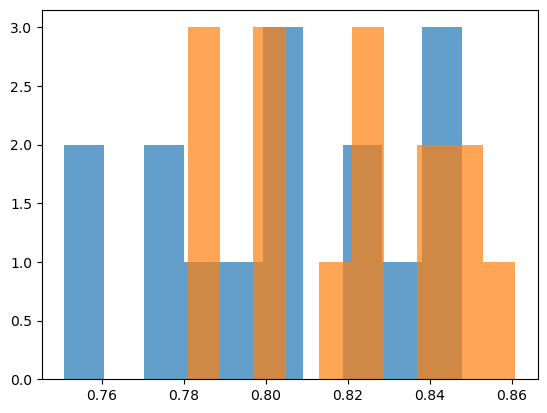

In [48]:
# plot dist
plt.hist(seed_df['model'], alpha = 0.7)
plt.hist(seed_df['human'], alpha = 0.7)
plt.show()

In [50]:
# run t-test
t_stat, p_value, df = sm.stats.ttest_ind(seed_df['model'], seed_df['human'])

print("T-statistic:", t_stat)
print("P-value:", p_value)
print("Degrees of freedom:", df)
if p_value < 0.05:
    print("SIGNIFICANT RESULT: REJECT THE NULL")
else:
    print("NOT A SIGNIFICANT RESULT: FAIL TO REJECT THE NULL")


T-statistic: -1.3835596447702874
P-value: 0.1774254454032819
Degrees of freedom: 28.0
NOT A SIGNIFICANT RESULT: FAIL TO REJECT THE NULL


In [51]:
# run ANOVA
model = ols('value ~ C(treatments)', data=seed_df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print()

                 sum_sq    df         F    PR(>F)
C(treatments)  0.001637   1.0  1.914237  0.177425
Residual       0.023949  28.0       NaN       NaN



In [52]:
# run tukey HSD test
m_comp = pairwise_tukeyhsd(endog=seed_df_melt['value'], groups=seed_df_melt['treatments'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 human  model  -0.0148 0.1774 -0.0366 0.0071  False
---------------------------------------------------


# Envs

In [53]:
# create dataframe
env_df = pd.DataFrame({
    'model': model_e_acc,
    'human': human_e_acc,
})
env_df_melt = pd.melt(env_df.reset_index(), id_vars=['index'], value_vars=['model', 'human'])
env_df_melt.columns = ['index', 'treatments', 'value']

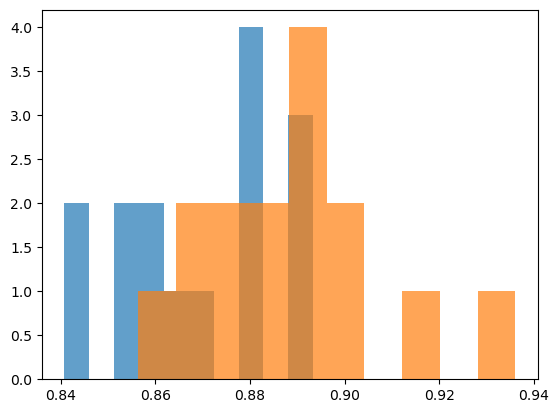

In [54]:
# plot dist
plt.hist(env_df['model'], alpha = 0.7)
plt.hist(env_df['human'], alpha = 0.7)
plt.show()

In [55]:
# run t-test
t_stat, p_value, df = sm.stats.ttest_ind(env_df['model'], env_df['human'])

print("T-statistic:", t_stat)
print("P-value:", p_value)
print("Degrees of freedom:", df)
if p_value < 0.05:
    print("SIGNIFICANT RESULT: REJECT THE NULL")
else:
    print("NOT A SIGNIFICANT RESULT: FAIL TO REJECT THE NULL")

T-statistic: -2.9305347333545355
P-value: 0.006665734703796617
Degrees of freedom: 28.0
SIGNIFICANT RESULT: REJECT THE NULL


In [56]:
# run ANOVA
model = ols('value ~ C(treatments)', data=env_df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print()

                 sum_sq    df         F    PR(>F)
C(treatments)  0.003013   1.0  8.588034  0.006666
Residual       0.009822  28.0       NaN       NaN



In [57]:
# run tukey HSD test
m_comp = pairwise_tukeyhsd(endog=env_df_melt['value'], groups=env_df_melt['treatments'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 human  model    -0.02 0.0067 -0.0341 -0.006   True
---------------------------------------------------


# Wings

In [58]:
# create dataframe
wing_df = pd.DataFrame({
    'model': model_w_acc,
    'human': human_w_acc,
})
wing_df_melt = pd.melt(wing_df.reset_index(), id_vars=['index'], value_vars=['model', 'human'])
wing_df_melt.columns = ['index', 'treatments', 'value']

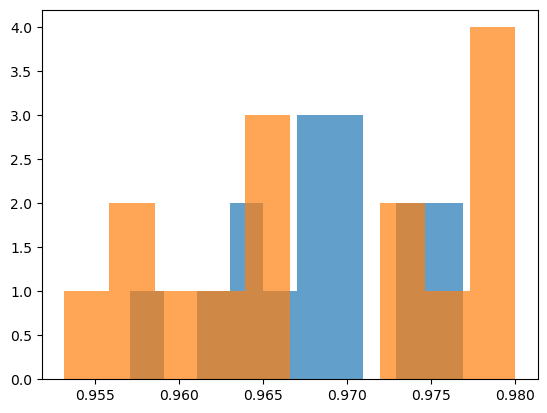

In [59]:
# plot dist
plt.hist(wing_df['model'], alpha = 0.7)
plt.hist(wing_df['human'], alpha = 0.7)
plt.show()

In [60]:
# run t-test
t_stat, p_value, df = sm.stats.ttest_ind(wing_df['model'], wing_df['human'])

print("T-statistic:", t_stat)
print("P-value:", p_value)
print("Degrees of freedom:", df)
if p_value < 0.05:
    print("SIGNIFICANT RESULT: REJECT THE NULL")
else:
    print("NOT A SIGNIFICANT RESULT: FAIL TO REJECT THE NULL")

T-statistic: 0.1217390346203126
P-value: 0.9039752084117083
Degrees of freedom: 28.0
NOT A SIGNIFICANT RESULT: FAIL TO REJECT THE NULL


In [61]:
# run ANOVA
model = ols('value ~ C(treatments)', data=wing_df_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print()

                     sum_sq    df        F    PR(>F)
C(treatments)  8.527848e-07   1.0  0.01482  0.903975
Residual       1.611157e-03  28.0      NaN       NaN



In [62]:
# run tukey HSD test
m_comp = pairwise_tukeyhsd(endog=wing_df_melt['value'], groups=wing_df_melt['treatments'], alpha=0.05)
print(m_comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper reject
-------------------------------------------------
 human  model   0.0003 0.904 -0.0053 0.006  False
-------------------------------------------------


# Plotting

In [63]:
# make total iou dict
ious = {}